In [1]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectFromModel

In [2]:
df_train = pd.read_csv('train.csv')
df_train2 = df_train.copy()
df_test = pd.read_csv('test.csv')
df_test2 = df_test.copy()

## EDA (forked Andrew Lukyanenko's visualization with some improvment)

In [3]:
import seaborn as sns
sns.set_style('whitegrid')

In [4]:
'''train = df_train2
plt.subplot(1,4,1)
train.groupby('type').mean()['rotting_flesh'].plot(kind='bar',figsize=(7,4), color='r',yerr=train.groupby('type').std()['rotting_flesh'],title='rotting_flesh')
plt.subplot(1,4,2,sharey=plt.subplot(1,4,1))
train.groupby('type').mean()['bone_length'].plot(kind='bar',figsize=(7,4), color='g',yerr=train.groupby('type').std()['bone_length'],title='bone_length')
plt.subplot(1,4,3,sharey=plt.subplot(1,4,1))
train.groupby('type').mean()['hair_length'].plot(kind='bar',figsize=(7,4), color='y',yerr=train.groupby('type').std()['hair_length'],title='hair_length')
plt.subplot(1,4,4,sharey=plt.subplot(1,4,1))
train.groupby('type').mean()['has_soul'].plot(kind='bar',figsize=(7,4), color='teal',yerr=train.groupby('type').std()['has_soul'],title='has_soul')

sns.factorplot("type", col="color", col_wrap=4, data=train, kind="count", size=2.4, aspect=.8)

corr = df_train2.select_dtypes(include = ['float64', 'int64']).iloc[:, 1:].corr()
plt.figure(figsize=(12, 12))

sns.heatmap(corr, vmax=1, square=True)
sns.pairplot(train, hue='type')

#The graphs look much better with higher figsize.
fig, ax = plt.subplots(2, 2, figsize = (16, 12))
sns.pointplot(x="color", y="rotting_flesh", hue="type", data=train, ax = ax[0, 0])
sns.pointplot(x="color", y="bone_length", hue="type", data=train, ax = ax[0, 1])
sns.pointplot(x="color", y="hair_length", hue="type", data=train, ax = ax[1, 0])
sns.pointplot(x="color", y="has_soul", hue="type", data=train, ax = ax[1, 1])
'''

'train = df_train2\nplt.subplot(1,4,1)\ntrain.groupby(\'type\').mean()[\'rotting_flesh\'].plot(kind=\'bar\',figsize=(7,4), color=\'r\',yerr=train.groupby(\'type\').std()[\'rotting_flesh\'],title=\'rotting_flesh\')\nplt.subplot(1,4,2,sharey=plt.subplot(1,4,1))\ntrain.groupby(\'type\').mean()[\'bone_length\'].plot(kind=\'bar\',figsize=(7,4), color=\'g\',yerr=train.groupby(\'type\').std()[\'bone_length\'],title=\'bone_length\')\nplt.subplot(1,4,3,sharey=plt.subplot(1,4,1))\ntrain.groupby(\'type\').mean()[\'hair_length\'].plot(kind=\'bar\',figsize=(7,4), color=\'y\',yerr=train.groupby(\'type\').std()[\'hair_length\'],title=\'hair_length\')\nplt.subplot(1,4,4,sharey=plt.subplot(1,4,1))\ntrain.groupby(\'type\').mean()[\'has_soul\'].plot(kind=\'bar\',figsize=(7,4), color=\'teal\',yerr=train.groupby(\'type\').std()[\'has_soul\'],title=\'has_soul\')\n\nsns.factorplot("type", col="color", col_wrap=4, data=train, kind="count", size=2.4, aspect=.8)\n\ncorr = df_train2.select_dtypes(include = [\'fl

In [5]:
#This is the tricky part, just by looking at the graph above, you will find the total number of colors other than {clear,white} 
#is approximately equal to those numbers of these two colors. So I group them up into 'rainbow' color. Hope this improves.
#Actually...it doesn't work well
'''df_train['color'] = df_train['color'].map({'clear':'clear','white':'white','green':'rainbow','black':'rainbow','blue':'rainbow','blood':'rainbow'})
df_test['color'] = df_test['color'].map({'clear':'clear','white':'white','green':'rainbow','black':'rainbow','blue':'rainbow','blood':'rainbow'})'''

"df_train['color'] = df_train['color'].map({'clear':'clear','white':'white','green':'rainbow','black':'rainbow','blue':'rainbow','blood':'rainbow'})\ndf_test['color'] = df_test['color'].map({'clear':'clear','white':'white','green':'rainbow','black':'rainbow','blue':'rainbow','blood':'rainbow'})"

In [6]:
color_label,type_label = LabelEncoder(),LabelEncoder()
#color_label =  color_label.fit(df_train['color'])
type_label = type_label.fit(df_train['type'])

item = [('color',color_label),('type',type_label)]

#df_train[item[0][0]] = item[0][1].transform(df_train[item[0][0]])
df_train[item[1][0]] = item[1][1].transform(df_train[item[1][0]])

#df_test[item[0][0]] = item[0][1].transform(df_test[item[0][0]])

#dummy encoding colors
df_train = df_train = pd.get_dummies(df_train,columns=['color'])
df_test = df_test = pd.get_dummies(df_test,columns=['color'])

#move 'type' to be the last column, which is my preference.(Don't be confused~)
df_train_type = df_train['type']
df_train = df_train.drop(['type'],axis=1)
df_train['type'] = df_train_type

In [7]:
def new_feature(df):
    #df.insert(5,'bone_hair_soul',df['bone_length']*df['hair_length']*df['has_soul'])
    df.insert(5,'bone_hair',df['bone_length']*df['hair_length'])
    #df.insert(6,'sin_bone',np.sin(df['bone_length']))
    df.insert(6,'bone_soul',df['bone_length']*df['has_soul'])
    #df.insert(7,'sin_soul',np.sin(df['has_soul']))
    df.insert(7,'hair_soul',df['hair_length']*df['has_soul'])
    #df.insert(8,'sin_hair',np.sin(df['hair_length']))
    #df.insert(6,'hair_flesh',df['hair_length']*df['rotting_flesh'])
    #df.insert(7,'soul_flesh',df['rotting_flesh']*df['has_soul'])
    #df.insert(8,'bone_flesh',df['bone_length']*df['rotting_flesh'])
    #df.insert(12,'bone_hari_soul_flesh',df['bone_length']*df['hair_length']*df['has_soul']*df['rotting_flesh'])
    #df.insert(13,'bone_hair_flesh',df['bone_length']*df['hair_length']*df['rotting_flesh'])
    #df.insert(14,'bone_soul_flesh',df['bone_length']*df['has_soul']*df['rotting_flesh'])
    #df.insert(15,'hair_soul_flesh',df['hair_length']*df['has_soul']*df['rotting_flesh'])
    
    
    
new_feature(df_train)
new_feature(df_test)

In [8]:
'''train = df_train.select_dtypes(include = ['float64', 'int64']).iloc[:, 1:]

corr = train.corr()
sns.heatmap(corr, vmax=1, square=True)

train['type'] = df_train_type
sns.pairplot(train, hue='type')'''

"train = df_train.select_dtypes(include = ['float64', 'int64']).iloc[:, 1:]\n\ncorr = train.corr()\nsns.heatmap(corr, vmax=1, square=True)\n\ntrain['type'] = df_train_type\nsns.pairplot(train, hue='type')"

In [9]:
'''df_train = df_train.drop(['hair_length','bone_length','has_soul'],axis = 1)
df_test = df_test.drop(['hair_length','bone_length','has_soul'],axis = 1)'''

"df_train = df_train.drop(['hair_length','bone_length','has_soul'],axis = 1)\ndf_test = df_test.drop(['hair_length','bone_length','has_soul'],axis = 1)"

In [10]:
'''#unfortunately, there is one exception in that its 'rotting_flesh' is 0.0000, which is bad.
df_test.loc[81,'rotting_flesh'] = 0.359289629561934 #mean value, somehow~

def new_feature(df):
    df.insert(5,'bone/flesh',df['bone_length']/df['rotting_flesh'])
    df.insert(6,'hair/flesh',df['hair_length']/df['rotting_flesh'])
    df.insert(7,'soul/flesh',df['has_soul']/df['rotting_flesh'])
    
new_feature(df_train)
new_feature(df_test)'''

"#unfortunately, there is one exception in that its 'rotting_flesh' is 0.0000, which is bad.\ndf_test.loc[81,'rotting_flesh'] = 0.359289629561934 #mean value, somehow~\n\ndef new_feature(df):\n    df.insert(5,'bone/flesh',df['bone_length']/df['rotting_flesh'])\n    df.insert(6,'hair/flesh',df['hair_length']/df['rotting_flesh'])\n    df.insert(7,'soul/flesh',df['has_soul']/df['rotting_flesh'])\n    \nnew_feature(df_train)\nnew_feature(df_test)"

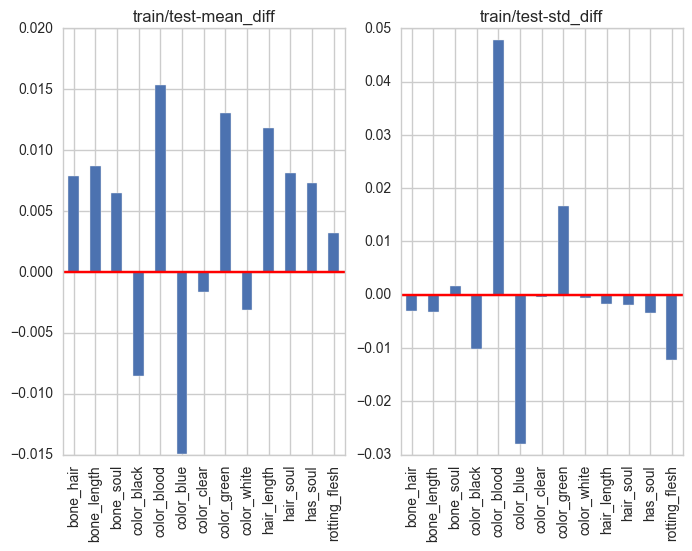

In [11]:
plt.subplot(1,2,1)
((df_train.mean()-df_test.mean()).drop(['id','type'])).plot(kind='bar');plt.axhline(0, color='r');plt.title('train/test-mean_diff')
plt.subplot(1,2,2)
((df_train.std()-df_test.std()).drop(['id','type'])).plot(kind='bar');plt.axhline(0, color='r');plt.title('train/test-std_diff')

### figure above shows the train_set and the test_set don't differ much

In [12]:
#If let 'color = -1'(color alwasys locates in the second last column of df_train, this is my preference), so include color.
#Otherwise, 'color = -4'(3 colors),or'-7'(6 colors) , so no color in our model.

color=-1

### **We've shown colors don't play a big role**

In [13]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import VotingClassifier

from sklearn.metrics import accuracy_score, log_loss

## My training_3:with test_set cheat

In [40]:
nn = pd.read_csv('submission_me3.csv')
df_test['type'] = type_label.transform(nn['type'])
data_test = df_test.values

In [41]:
color = -1 # better to have no color

In [42]:
data = df_train.values
data_test = np.random.permutation(data_test)
        
data_new = np.vstack((data,data_test[:,:]))
data_new = np.random.permutation(data_new)
    
x_train = data_new[:,1:color]
y_train = data_new[:,-1]
#x_train = data[:,1:color]
#y_train = data[:,-1]
    
xtrain, xtest, ytrain, ytest = train_test_split(x_train, y_train, test_size=0.2)
ytest = [int(x) for x in ytest]

x_test = df_test.values[:,1:color]

In [43]:
classifiers = [
    MLPClassifier(hidden_layer_sizes = (8,),solver='lbfgs'),
    KNeighborsClassifier(3),
    NuSVC(probability=True),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]

# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(xtrain, ytrain)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(xtest)
    acc = accuracy_score(ytest, train_predictions)
    print("Accuracy: {:.4%}".format(acc))
    
    train_predictions = clf.predict_proba(xtest)
    ll = log_loss(ytest, train_predictions)
    print("Log Loss: {}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*30)

MLPClassifier
****Results****
Accuracy: 87.7778%
Log Loss: 0.3339615160778899
KNeighborsClassifier
****Results****
Accuracy: 78.8889%
Log Loss: 2.193335016693276
NuSVC
****Results****
Accuracy: 88.3333%
Log Loss: 0.34046237556056336
RandomForestClassifier
****Results****
Accuracy: 86.1111%
Log Loss: 0.8846992538417495
AdaBoostClassifier
****Results****
Accuracy: 76.6667%
Log Loss: 0.7544369530964748
GradientBoostingClassifier
****Results****
Accuracy: 82.2222%
Log Loss: 0.3775972912175959
GaussianNB
****Results****
Accuracy: 82.7778%
Log Loss: 0.6064528173558653
LinearDiscriminantAnalysis
****Results****
Accuracy: 83.3333%
Log Loss: 0.4044178716355138
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 74.4444%
Log Loss: 1.13118500192029


C:\Users\YuHang\AppData\Roaming\Python\Python35\site-packages\sklearn\discriminant_analysis.py:389: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\YuHang\AppData\Roaming\Python\Python35\site-packages\sklearn\discriminant_analysis.py:694: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [44]:
j = [str(j) for j in range(len(classifiers))]
est = zip(j,classifiers)

In [45]:
clf = VotingClassifier(estimators=list(est),voting='soft')

clf.fit(xtrain,ytrain)
    #clf.fit(x_train,y_train)
    
y_val_l = clf.predict_proba(xtest)
cv_score = sum(pd.DataFrame(y_val_l, columns=type_label.classes_).idxmax(axis=1).values
                                   == type_label.inverse_transform(ytest))/len(ytest)
print("Validation accuracy: ", cv_score)

pred = clf.predict(x_test)

pred = [int(x) for x in pred]

sub = pd.read_csv('sample_submission.csv')
type_pred = type_label.inverse_transform(pred)
sub['type'] = type_pred

sub.to_csv('submission_me2.csv',index=False)

Validation accuracy:  0.833333333333


C:\Users\YuHang\AppData\Roaming\Python\Python35\site-packages\sklearn\discriminant_analysis.py:389: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\YuHang\AppData\Roaming\Python\Python35\site-packages\sklearn\discriminant_analysis.py:694: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [46]:
df1 = pd.read_csv('submission_me3.csv')
df2 = pd.read_csv('submission_me2.csv')

ne = (df1 != df2).any(1)
ne_stacked = (df1 != df2).stack()
changed = ne_stacked[ne_stacked]
changed.index.names = ['id', 'col']
difference_locations = np.where(df1 != df2)
changed_from = df1.values[difference_locations]
changed_to = df2.values[difference_locations]
pd.DataFrame({'from': changed_from, 'to': changed_to}, index=changed.index)

,,from,to
id,col,,
3,type,Ghost,Goblin
23,type,Ghost,Goblin
24,type,Ghoul,Goblin
36,type,Ghost,Goblin
51,type,Goblin,Ghoul
64,type,Goblin,Ghoul
70,type,Ghost,Goblin
96,type,Ghost,Goblin
102,type,Ghoul,Goblin


In [49]:
for i in difference_locations[0]:
    a = df1.loc[i,'type']
    b = df2.loc[i,'type']
    #print(a,b)
    if b == 'Goblin' and i not in [76,150]:
        df1.set_value(i,'type',b)

In [50]:
print(df1[df1['type'] == 'Goblin'].count())
print(df1[df1['type'] == 'Ghost'].count())
print(df1[df1['type'] == 'Ghoul'].count())

id      168
type    168
dtype: int64
id      187
type    187
dtype: int64
id      174
type    174
dtype: int64


In [48]:
print(df2[df2['type'] == 'Goblin'].count())
print(df2[df2['type'] == 'Ghost'].count())
print(df2[df2['type'] == 'Ghoul'].count())

id      161
type    161
dtype: int64
id      188
type    188
dtype: int64
id      180
type    180
dtype: int64


In [52]:
df1.to_csv('submission_me5.csv',index=False)

In [25]:
pred = clf.predict_proba(x_test)

In [26]:
pred[difference_locations[0]]

array([[ 0.18048432,  0.35543651,  0.46407917],
       [ 0.01006633,  0.59556553,  0.39436815],
       [ 0.01802437,  0.45117379,  0.53080184],
       [ 0.35866201,  0.12023403,  0.52110396],
       [ 0.00393235,  0.74079017,  0.25527748],
       [ 0.2565086 ,  0.182805  ,  0.5606864 ],
       [ 0.00731027,  0.42481907,  0.56787066],
       [ 0.4063553 ,  0.04910496,  0.54453973],
       [ 0.01161332,  0.56219448,  0.42619221],
       [ 0.01231487,  0.40775205,  0.57993308],
       [ 0.00537375,  0.63523275,  0.3593935 ],
       [ 0.00562843,  0.48173419,  0.51263738],
       [ 0.24099794,  0.14246477,  0.61653729],
       [ 0.01862722,  0.45347277,  0.52790001],
       [ 0.01631828,  0.57760301,  0.40607871],
       [ 0.02997167,  0.2790919 ,  0.69093643],
       [ 0.01092973,  0.4582162 ,  0.53085407],
       [ 0.00616729,  0.49841731,  0.4954154 ],
       [ 0.00927704,  0.7233912 ,  0.26733176],
       [ 0.06228629,  0.30580044,  0.63191327],
       [ 0.38689838,  0.08555826,  0.527

In [27]:
np.argmax(pred[difference_locations[0]], axis=1)

array([2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 0, 2,
       2, 2, 2, 2, 1, 1, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2,
       1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1], dtype=int32)